## Predicting Zestimate Logerror

## Executive Summary:
- clustering did not significantly improve the modeling process when incorporated as a feature
- clustering was helpful in identifying and narrowing variable connection to the target variable, LOGERROR
- I found SQ FT, YR BUILT and FIPS to be the main drivers of LOGERROR

## Project Goal:
- Use clusters to help your exploration, understanding, and modeling of the data.

- The target variable you are trying to predict is logerror (b/c this is a regression problem since logerror is continuous)

- BUT if you use a cluster number as a feature, that cluster should not have the target variable of logerror in it.

## 1. Wrangle

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
import env
import os
import sklearn.preprocessing
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
import wrangle
from scipy import stats
# reloads import files each time a cell is ran
%load_ext autoreload
%autoreload 2

In [2]:
#acquire the zillow data
full_df = wrangle.get_zillow_data()

### Notes:
 - initial SQL query returned 69 columns and 52442 rows

In [3]:
df = wrangle.wrangle_zillow()
df.info()

['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet', 'lotsizesquarefeet', 'roomcnt', 'yearbuilt', 'taxvaluedollarcnt']
       bathroomcnt  bedroomcnt  calculatedfinishedsquarefeet  \
0         1.173897    0.736871                      1.172918   
1         1.270673    1.370886                      0.456237   
2         0.292845    0.317008                      0.677444   
3         0.684983    0.736871                      0.451506   
4         0.684983    0.736871                      1.035411   
...            ...         ...                           ...   
52437     0.292845    1.370886                      0.634597   
52438     0.292845    0.736871                      0.309763   
52439     1.270673    0.317008                      0.887689   
52440     0.292845    0.317008                      0.160299   
52441     0.292845    0.317008                      0.869754   

       lotsizesquarefeet   roomcnt  yearbuilt  taxvaluedollarcnt  
0               0.079053  0.601872  

### down to 50,449 rows and 21 columns.
### started with 52,442 from the initial SQL query

## Understanding the target variable:
1. The target variable is logerror
2. 𝑙𝑜𝑔𝑒𝑟𝑟𝑜𝑟=𝑙𝑜𝑔(𝑍𝑒𝑠𝑡𝑖𝑚𝑎𝑡𝑒)−𝑙𝑜𝑔(𝑆𝑎𝑙𝑒𝑃𝑟𝑖𝑐𝑒)
    - its log(zillow's estimated home price) - log(actual sale price)
    - I have logerror
    - I have an approximation of the estimated home price in taxvaluedollarcnt
    - therefore: logerror + log(taxvaluedollarcount) = log(zillow estimated home price)

In [4]:
df.head()

,logerror,transactiondate,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,latitude,longitude,lotsizesquarefeet,roomcnt,yearbuilt,taxvaluedollarcnt
0,0.025595,2017-01-01,3.5,4.0,3100.0,orange_county,33634931.0,-117869207.0,4506.0,0.0,1998.0,1023282.0
1,0.055619,2017-01-01,1.0,2.0,1465.0,ventura,34449266.0,-119281531.0,12647.0,5.0,1967.0,464000.0
2,0.005383,2017-01-01,2.0,3.0,1243.0,orange_county,33886168.0,-117823170.0,8432.0,6.0,1962.0,564778.0
3,-0.103410,2017-01-01,3.0,4.0,2376.0,los_angeles,34245180.0,-118240722.0,13038.0,0.0,1970.0,145143.0
4,-0.001011,2017-01-01,3.0,4.0,2962.0,los_angeles,34145202.0,-118179824.0,63000.0,0.0,1950.0,773303.0


<AxesSubplot:>

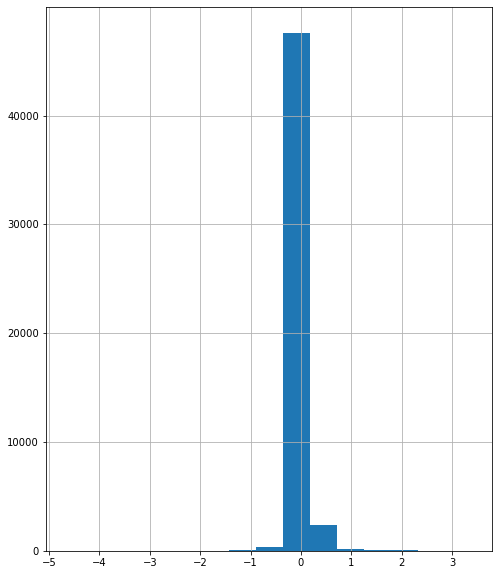

In [5]:
df.logerror.hist(figsize=(8, 10), bins=15)

array([[<AxesSubplot:title={'center':'logerror'}>,
        <AxesSubplot:title={'center':'bathroomcnt'}>,
        <AxesSubplot:title={'center':'bedroomcnt'}>],
       [<AxesSubplot:title={'center':'calculatedfinishedsquarefeet'}>,
        <AxesSubplot:title={'center':'lotsizesquarefeet'}>,
        <AxesSubplot:title={'center':'roomcnt'}>],
       [<AxesSubplot:title={'center':'yearbuilt'}>,
        <AxesSubplot:title={'center':'taxvaluedollarcnt'}>,
        <AxesSubplot:>]], dtype=object)

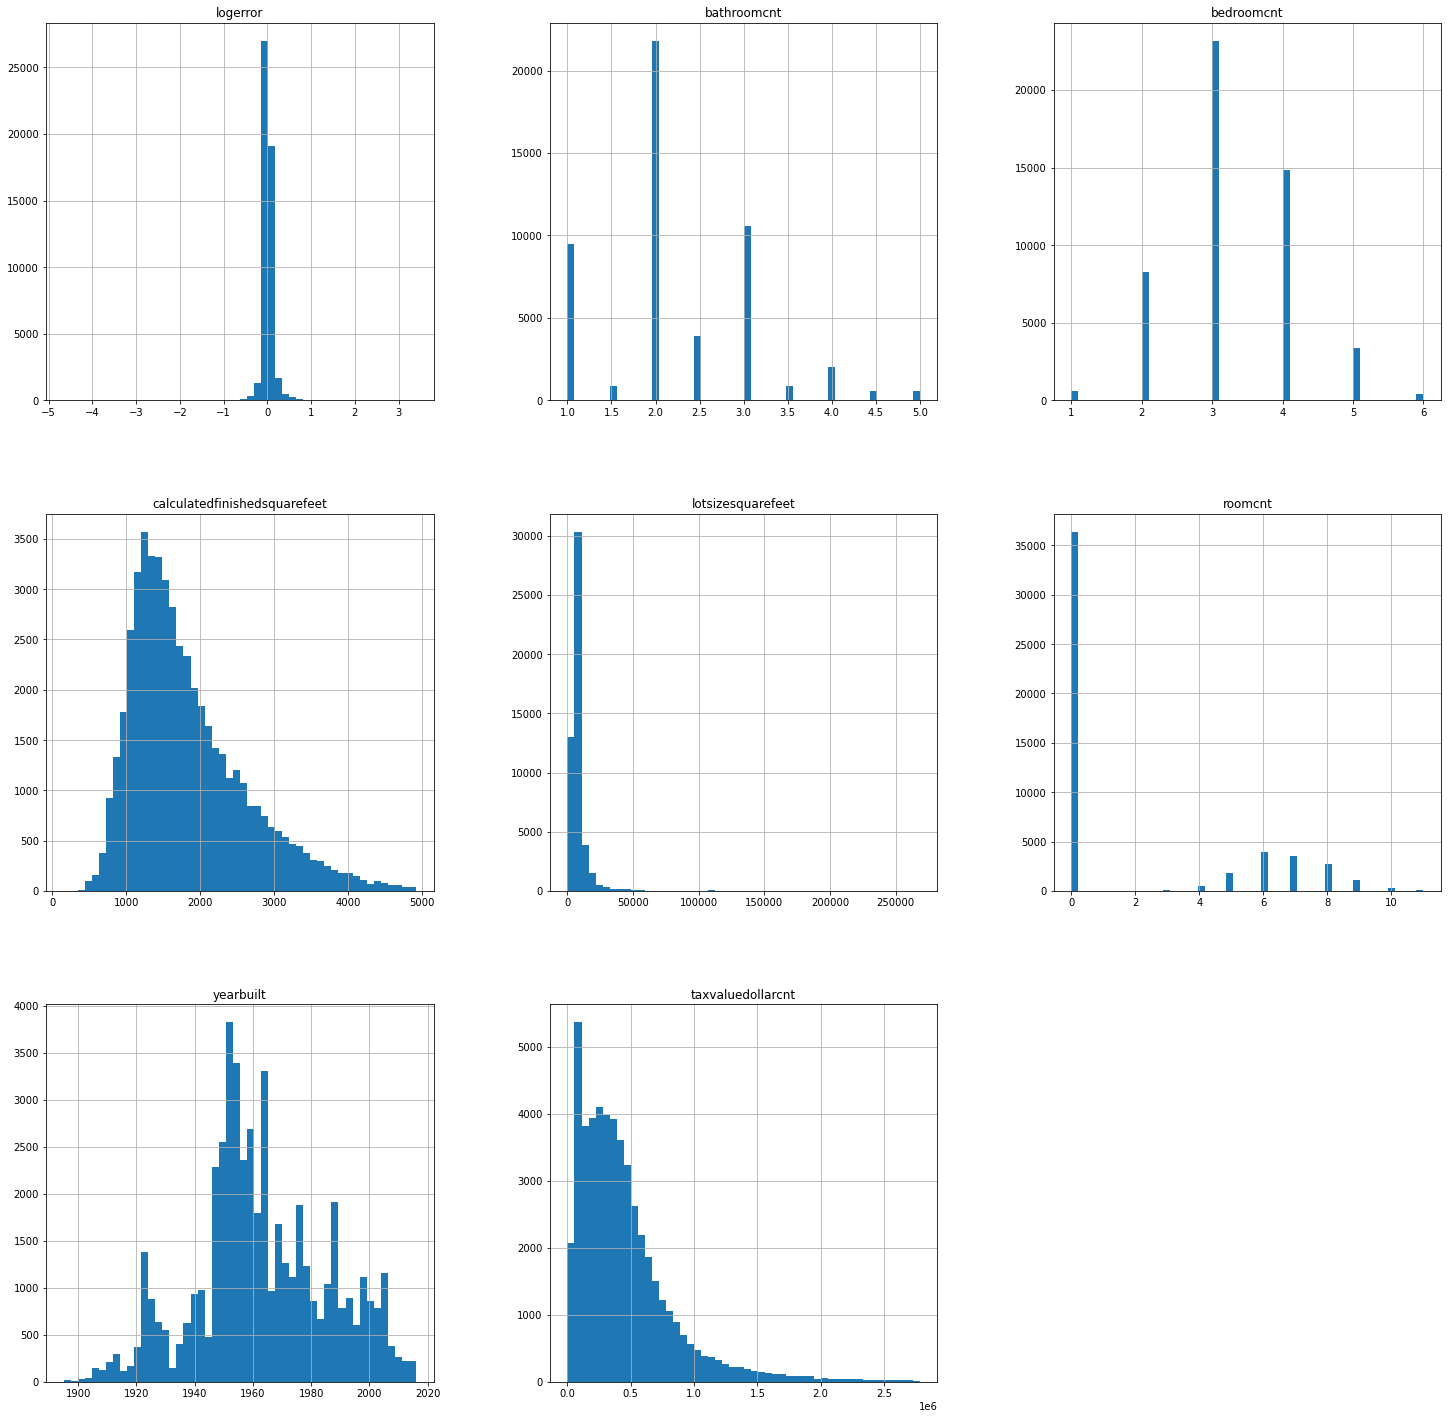

In [6]:
df.hist(figsize=(25, 25), bins=50)

### Takeaways from single variable distributions:
- logerror is normal, centered on 0
- baths is right skewed, centered on 2
- beds is right skewed, centered on 4
- finishedsqft is right skewed, centered 2500
- fips is divided unequally among 3 counties, with LA highest
- roomcnt has a normal dist around 6.5, where not null or 0 (lots of zeroes). Is the number of zeroes throwing off the zestimate? I'm going to drop this from my modeling df
- year built is is right skewed, centered on 1950-60
- get rid of columns with mainly one value:
    - assessemnt year
    - unitcnt
    - finishedsquareft12 is same as calculatedfinishedsqft
- make zips/ids into objects:
    - regionidzip
    - regionidcounty
    - regionidcity

### I'm creating 'logerror_bins' so that I can isolate high logerror rows from the DF and then investigate the drivers of logerror in those cases

In [7]:
bins = [-4.33, -2.33, -1.8, -1.0, -0.75, -0.5, -0.25, 0, 0.25, 0.5, 0.75, 1, 1.8, 2.33, 4.33 ]
df['logerror_bins'] = pd.cut(df.logerror, bins)


## I'm creating 'zillow_price_est' so that I can directly compare it with taxvaluedollarcnt
- ln(error) + ln(taxvaluedollarcount) = ln(zillow estimated home price)
- inv.ln(logerr + log(taxvaluedollarcnt)) = zillow estimated home price


In [8]:
df['zillow_price_est'] = np.e**((df.logerror) + np.log(df.taxvaluedollarcnt))
df.zillow_price_est.mean()

473844.4421851064

## Create zillow error to get price estimate error in dollars

In [9]:
df['zillow_error'] = df.zillow_price_est - df.taxvaluedollarcnt
df.zillow_error.mean()

19650.526577832035

In [10]:
df.groupby('logerror_bins').agg(["min","max","mean", "count"]).logerror.T

logerror_bins,"(-4.33, -2.33]","(-2.33, -1.8]","(-1.8, -1.0]","(-1.0, -0.75]","(-0.75, -0.5]","(-0.5, -0.25]","(-0.25, 0.0]","(0.0, 0.25]","(0.25, 0.5]","(0.5, 0.75]","(0.75, 1.0]","(1.0, 1.8]","(1.8, 2.33]","(2.33, 4.33]"
min,-2.406257,-2.327432,-1.738639,-0.996519,-0.748125,-0.497263,-0.249966,0.000003,0.250120,0.501805,0.751347,1.001120,1.804495,2.332701
max,-2.330162,-1.866832,-1.009838,-0.750781,-0.500204,-0.250277,-0.000002,0.249965,0.497845,0.749906,0.998868,1.794840,2.326512,3.394544
mean,-2.363986,-2.217180,-1.258332,-0.867657,-0.602182,-0.335216,-0.044967,0.047357,0.342936,0.602809,0.857289,1.287204,2.172758,2.578077
count,4.000000,19.000000,26.000000,53.000000,105.000000,550.000000,21326.000000,26939.000000,1081.000000,281.000000,103.000000,95.000000,61.000000,28.000000


In [11]:
df.logerror.describe()

count    50673.000000
mean         0.017469
std          0.171793
min         -4.655420
25%         -0.024704
50%          0.006492
75%          0.039225
max          3.394544
Name: logerror, dtype: float64

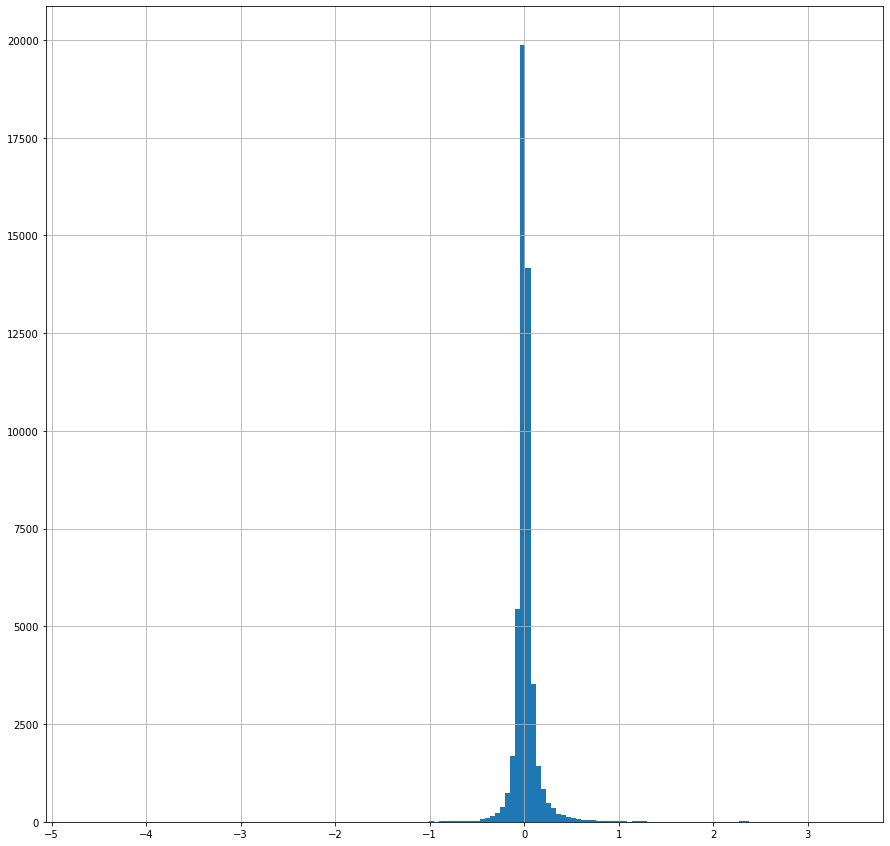

In [12]:
df.logerror.hist(bins=150, figsize=(15, 15))
plt.show()

## 2. Explore

In [13]:
df.dtypes

logerror                         float64
transactiondate                   object
bathroomcnt                      float64
bedroomcnt                       float64
calculatedfinishedsquarefeet     float64
fips                              object
latitude                          object
longitude                         object
lotsizesquarefeet                float64
roomcnt                          float64
yearbuilt                        float64
taxvaluedollarcnt                float64
logerror_bins                   category
zillow_price_est                 float64
zillow_error                     float64
dtype: object

In [14]:
import split

In [15]:
train, validate, test = split.train_validate_test_split(df,'logerror')
train.shape, validate.shape, test.shape

((28376, 15), (12162, 15), (10135, 15))

In [16]:
# top 5% of train dataset (~3 std from mean)
high_outliers = train.logerror.quantile(q=0.95)
# top 16% of train dataset (~2 std from mean)
upper_mid_outliers = train.logerror.quantile(q=0.84)
# bottom 16 of train dataset (~2 std from mean)
lower_mid_outliers = train.logerror.quantile(q=0.16)
# bottom 5% percent of dataset (~3 std from mean)
low_outliers = train.logerror.quantile(q=0.05)

In [17]:
high_outliers.min()

0.18480391105849997

In [18]:
high_outliers.max()

0.18480391105849997

In [19]:
#upper-high outliers are top 5% of the data
train_high_outliers = train[train.logerror > high_outliers]
# mid-outliers are between 95-86 percentiles
train_upper_mid_outliers = train[(train.logerror < high_outliers) & (train.logerror > upper_mid_outliers)]
# center-mass data will be 86-16 percentiles
train_center_mass = train[(train.logerror > lower_mid_outliers) & (train.logerror < upper_mid_outliers)]
# lower mid will be 16-5 percentiles
train_lower_mid_outliers = train[(train.logerror < lower_mid_outliers) & (train.logerror > low_outliers)]
# low outliers are bottom 5% of data
train_low_outliers = train[train.logerror < low_outliers]

In [20]:
train_high_outliers.head()

,logerror,transactiondate,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,latitude,longitude,lotsizesquarefeet,roomcnt,yearbuilt,taxvaluedollarcnt,logerror_bins,zillow_price_est,zillow_error
6077,0.682494,2017-02-10,2.0,3.0,1664.0,los_angeles,34564547.0,-117951796.0,45552.0,0.0,1989.0,113633.0,"(0.5, 0.75]",2.248578e+05,1.112248e+05
42971,0.249837,2017-08-03,2.0,3.0,1305.0,ventura,34347921.0,-119086382.0,5984.0,6.0,1973.0,260054.0,"(0.0, 0.25]",3.338614e+05,7.380741e+04
4360,1.241767,2017-01-30,2.5,3.0,1737.0,orange_county,33634757.0,-117880460.0,1994.0,6.0,1966.0,947794.0,"(1.0, 1.8]",3.281002e+06,2.333208e+06
24814,0.282481,2017-05-17,1.0,2.0,985.0,los_angeles,33922357.0,-118291926.0,6997.0,0.0,1954.0,41990.0,"(0.25, 0.5]",5.569621e+04,1.370621e+04
51178,0.391733,2017-09-12,3.0,4.0,2445.0,los_angeles,34178295.0,-118659793.0,11728.0,0.0,1967.0,457450.0,"(0.25, 0.5]",6.768170e+05,2.193670e+05


In [21]:
numeric_cols = train.select_dtypes('float64').columns
non_numeric_cols = train.select_dtypes('object').columns

In [22]:
train_numeric = train[train.select_dtypes('float64').columns]
train_non_numeric = train[train.select_dtypes('object').columns]

### Now that I have built the outlier subsets, I want to visually show the variable relationships for:
- train dataset vs. high outliers vs. upper-mid vs. center mass vs. low-mid vs. low
- scatter plots for quant variables
- add hue for interesting categorical columns like fips
- Note: I'm going to need to build subplots for this

In [23]:
train.head(5)

,logerror,transactiondate,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,latitude,longitude,lotsizesquarefeet,roomcnt,yearbuilt,taxvaluedollarcnt,logerror_bins,zillow_price_est,zillow_error
3323,-0.021395,2017-01-24,2.0,3.0,1115.0,los_angeles,34212796.0,-118543472.0,13043.0,0.0,1956.0,254647.0,"(-0.25, 0.0]",249256.585265,-5390.414735
2470,-0.023569,2017-01-18,1.0,2.0,1754.0,los_angeles,34105205.0,-118108463.0,8666.0,0.0,1938.0,582447.0,"(-0.25, 0.0]",568879.837510,-13567.162490
7019,-0.083987,2017-02-16,3.0,4.0,2497.0,los_angeles,34465169.0,-118494179.0,18496.0,0.0,1989.0,462901.0,"(-0.25, 0.0]",425611.362951,-37289.637049
50112,-0.039345,2017-09-06,3.0,3.0,1780.0,los_angeles,34567611.0,-118172344.0,5069.0,0.0,2005.0,260000.0,"(-0.25, 0.0]",249968.984278,-10031.015722
48192,-0.048605,2017-08-29,2.0,5.0,1875.0,los_angeles,33966020.0,-118023774.0,5940.0,0.0,1951.0,522149.0,"(-0.25, 0.0]",497376.640046,-24772.359954


# Questions I want to answer graphically and statistically:
1. Does high logerror occur more freguently in some counties than others, proportionally?
2. Does logerror have a relationship to certain sq_ft ranges?
3. Is high logerror correlated to certain yearbuilt ranges?

In [24]:
# top 5% of train dataset (~3 std from mean)
high_outliers = train.logerror.quantile(q=0.95)
# top 16% of train dataset (~2 std from mean)
upper_mid_outliers = train.logerror.quantile(q=0.84)
# bottom 16 of train dataset (~2 std from mean)
lower_mid_outliers = train.logerror.quantile(q=0.16)
# bottom 5% percent of dataset (~3 std from mean)
low_outliers = train.logerror.quantile(q=0.05)


#upper-high outliers are top 5% of the data
train_high_outliers = train[train.logerror > high_outliers]
# mid-outliers are between 95-86 percentiles
train_upper_mid_outliers = train[(train.logerror < high_outliers) & (train.logerror > upper_mid_outliers)]
# center-mass data will be 86-16 percentiles
train_center_mass = train[(train.logerror < upper_mid_outliers) & (train.logerror > lower_mid_outliers)]
# lower mid will be 16-5 percentiles
train_lower_mid_outliers = train[(train.logerror < lower_mid_outliers) & (train.logerror > low_outliers)]
# low outliers are bottom 5% of data
train_low_outliers = train[train.logerror < low_outliers]



# Average churn in the population, by tenure
data1 = train
data2 = train_high_outliers
data3 = train_upper_mid_outliers
data4= train_center_mass
data5 = train_lower_mid_outliers
data6 = train_low_outliers


## Q1: Does high logerror occur more freguently in some counties than others, controlling for dataset size?

Text(0.5, 0.98, 'FIPS v. Logerror for (1) Population, (2) Center Mass, (3) High Outliers, \n(4) Upper-Mid Outliers, (5) Lower-Mid Outliers, (6) Low Outliers')

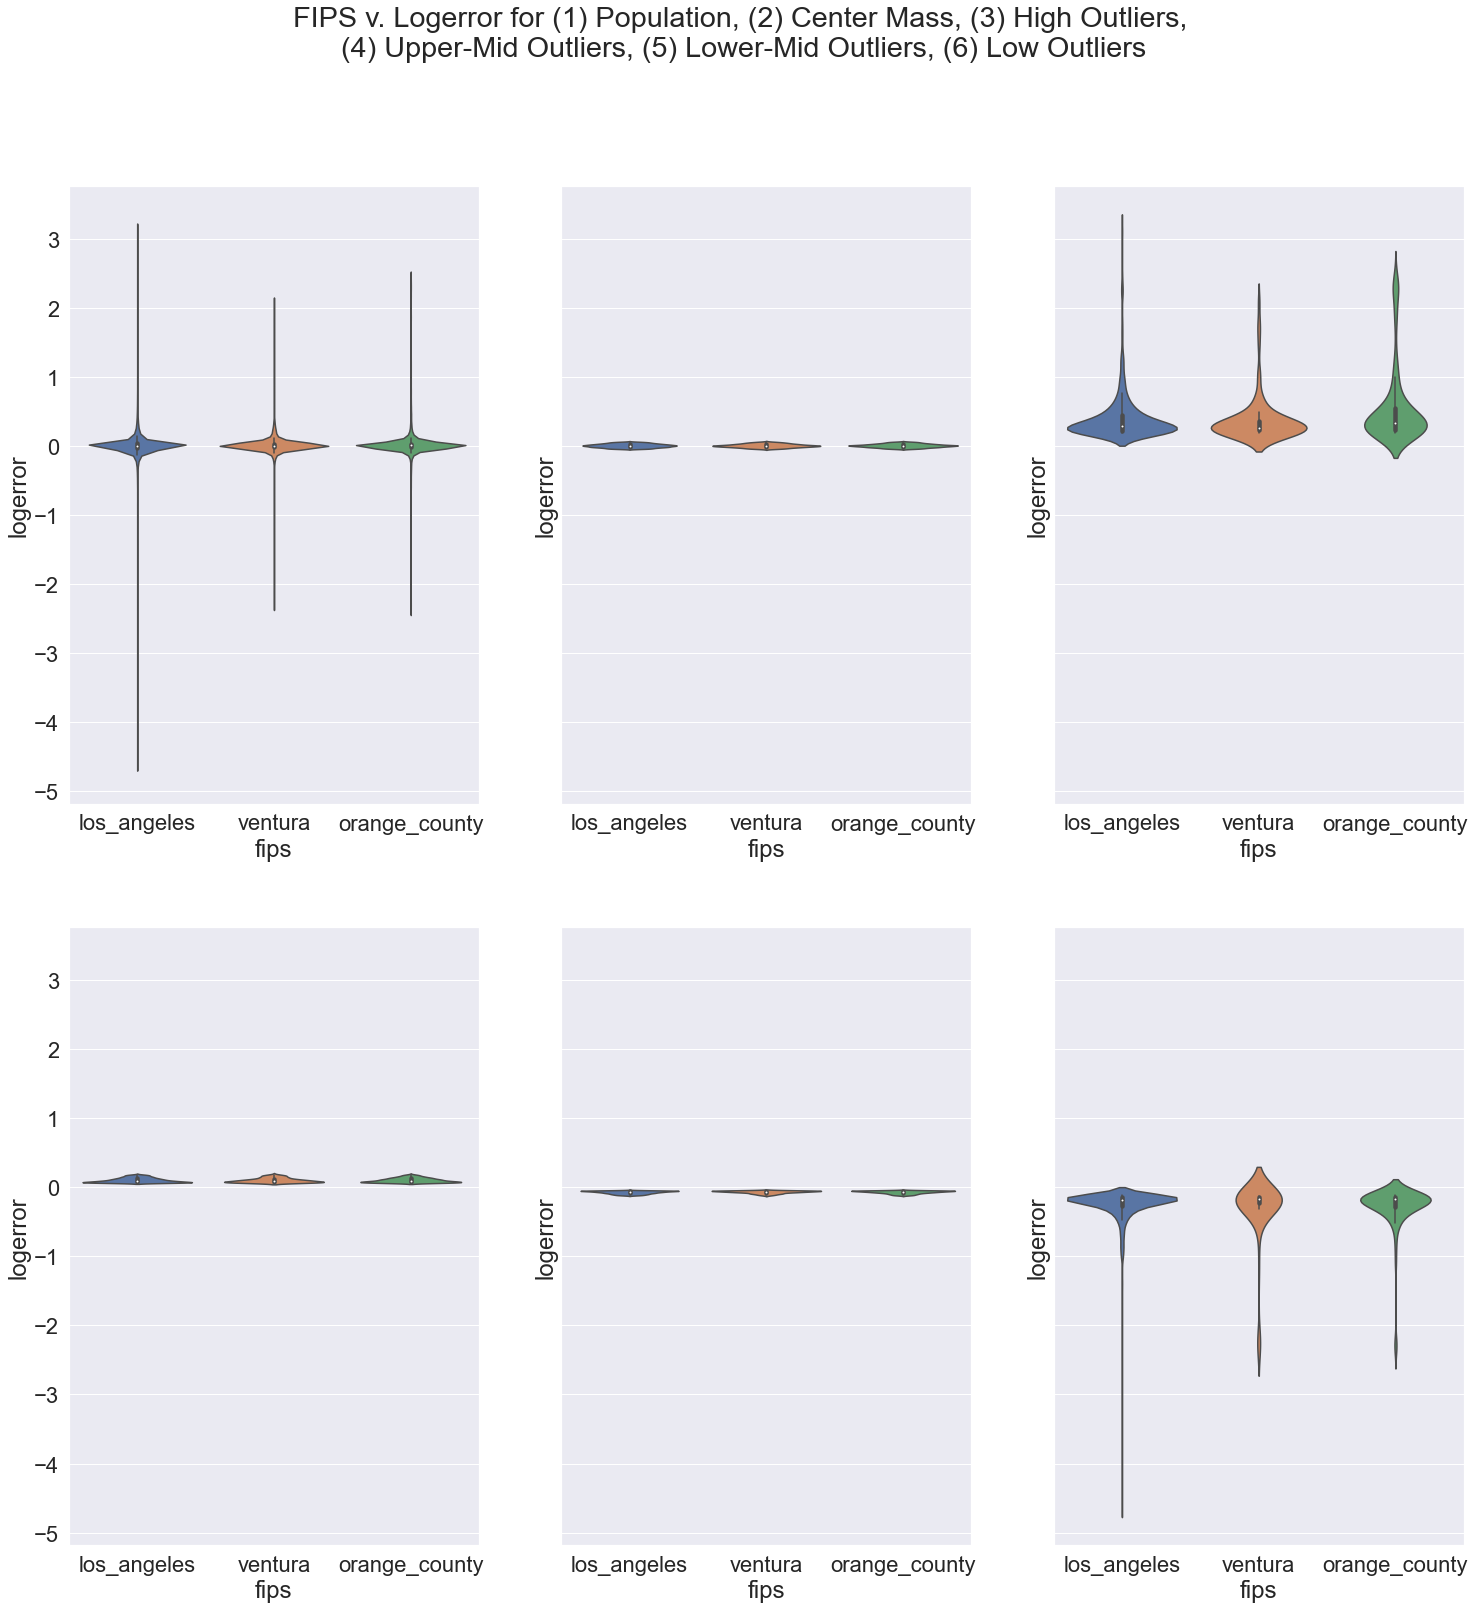

In [25]:
sns.set(font_scale = 2, rc={"figure.figsize":(25,25)})
fig, axes = plt.subplots(2, 3, sharey=True)

sns.violinplot(x='fips', y='logerror', data=data1, ax=axes[0,0], order=["los_angeles", "ventura", "orange_county"])
sns.violinplot(x='fips', y='logerror', data=data4, ax=axes[0,1], order=["los_angeles", "ventura", "orange_county"])
sns.violinplot(x='fips', y='logerror', data=data2, ax=axes[0,2], order=["los_angeles", "ventura", "orange_county"])
sns.violinplot(x='fips', y='logerror', data=data3, ax=axes[1,0], order=["los_angeles", "ventura", "orange_county"])
sns.violinplot(x='fips', y='logerror', data=data5, ax=axes[1,1], order=["los_angeles", "ventura", "orange_county"])
sns.violinplot(x='fips', y='logerror', data=data6, ax=axes[1,2], order=["los_angeles", "ventura", "orange_county"])
fig.suptitle("""FIPS v. Logerror for (1) Population, (2) Center Mass, (3) High Outliers, 
(4) Upper-Mid Outliers, (5) Lower-Mid Outliers, (6) Low Outliers""")

## Visual Takeaway: 
- it seems like between sets:
    - number_los_angeles_high_outliers > number_orange_county_high_outliers > number_ventura_high_outliers
    - number_los_angeles_low_outliers > number_orange_county_low_outliers > number_ventura_low_outliers
    - orange county has the greatest number of outliers > 1.5 logerror
- it seems like within sets:
    - los_angeles has more high outliers than low outliers, but the range of low outliers is greater than the range of high outliers (0:~-4.6)
    - same with ventura, but ventura has a less severe lower range (0:~-2.8)
    - orange_county is evenly balnaced, but has a flare in the upper outliers, from (1.5:2.8)

## Let's run statistical tests to determine if, proportionally, LA has a higher percentage of outliers of its data set than the other two counties
- I want to know if (LA_high_outliers/LA_data) > (ventura_high_outliers/ventura_data), and if (LA_high_outliers/LA_data) > (oc_high_outliers/oc_data)

    - Null hypothesis1: LA high outliers make up less/equal proportion of high outliers in comparison to Ventura county outliers
    - Alt hypothesis1: LA high outliers make up greater proportion of high outliers in comparison to Ventura county outliers

    - Null hypothesis2: LA high outliers make up less/equal proportion of high outliers in comparison to Orange County outliers
    - Alt hypothesis2: LA high outliers make up greater proportion of high outliers in comparison to Orange County outliers
    
- I want to know if (LA_low_outliers/LA_data) > (ventura_low_outliers/ventura_data), and if (LA_low_outliers/LA_data) > (oc_low_outliers/oc_data)
    - Null hypothesis1: LA low outliers make up less/equal proportion of low outliers in comparison to Ventura county outliers
    - Alt hypothesis1: LA low outliers make up greater proportion of low outliers in comparison to Ventura county outliers

    - Null hypothesis2: LA low outliers make up less/equal proportion of low outliers in comparison to Orange County outliers
    - Alt hypothesis2: LA low outliers make up greater proportion of low outliers in comparison to Orange County outliers

## Which test am I going to use?
- We are testing proportions and group membership on two categorical variables, so this will be a chi2 test.
- print the contingency taables 
- establish group membership
- answer: is one county more likely to be represented propotionally in the high outlier/low outlier data?

## A. For the positive, large outliers:

In [26]:
# first, get the contingency table of expected vs. observed porportions. 

#get the counts of the high outliers in each county
la_count = train_high_outliers[(train_high_outliers.fips=='los_angeles')].shape[0] 
ventura_count = train_high_outliers[(train_high_outliers.fips=='ventura')].shape[0] 
oc_count = train_high_outliers[(train_high_outliers.fips=='orange_county')].shape[0] 

#get the proportions of county high outliers in the total county dataset (should be about 5%) to see proportion of data in each county that is a logerror outlier
# (count of outliers in county)/(count of data in the county) = (outliers/county)*100 = the percentage of high outliers per county
la_county_prop = (la_count/ train[(train.fips=='los_angeles')].shape[0])*100 
ventura_county_prop = (ventura_count/train[(train.fips=='ventura')].shape[0]) *100
oc_county_prop = (oc_count/train[(train.fips=='orange_county')].shape[0]) *100

#get the proportions of county high outliers in the high outliers dataset to see proportion of high error outliers made up by each county
la_total_prop = (la_count/ train_high_outliers.shape[0])*100 
ventura_total_prop = (ventura_count/train_high_outliers.shape[0])*100
oc_total_prop = (oc_count/train_high_outliers.shape[0])*100

In [27]:

degf=2
index = ['Count', 'Proportion_of_County', 'Proportion_of_Total']
columns = ['Los_Angeles', 'Ventura', 'Orange_County']

observed = pd.DataFrame([[la_count, ventura_count, oc_count], 
                        [la_county_prop, ventura_county_prop, oc_county_prop],
                        [la_total_prop, ventura_total_prop, oc_total_prop]], 
                        index=index, columns=columns).round(2)
observed = observed.T
observed

,Count,Proportion_of_County,Proportion_of_Total
Los_Angeles,1031.0,5.61,72.66
Ventura,96.0,4.04,6.77
Orange_County,292.0,3.83,20.58


                Count  Proportion_of_County  Proportion_of_Total
Los_Angeles    1031.0                  5.61                72.66
Ventura          96.0                  4.04                 6.77
Orange_County   292.0                  3.83                20.58
         0     1      2
0  1027.12  9.76  72.39
1    98.90  0.94   6.97
2   292.98  2.78  20.65
a is: 0.05
p is: 0.014005912116086837
we reject the null hypothesis that county and large, positive outlier membership are independent


([<matplotlib.axis.XTick at 0x7fd51d263e20>,
 [Text(0, 0, 'Los_Angeles'),
  Text(1, 0, 'Ventura'),
  Text(2, 0, 'Orange_County')])

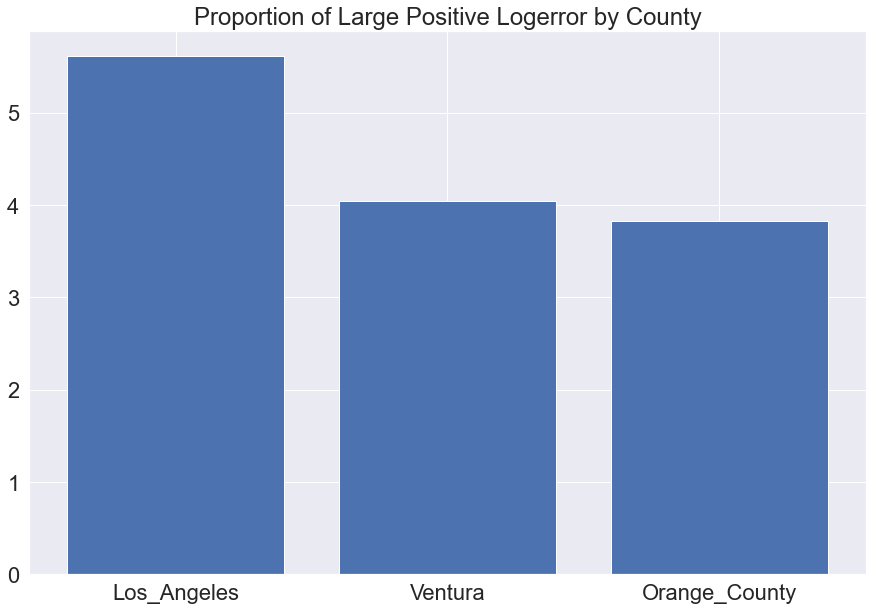

In [28]:
a = 0.05

chi2, p, degf, expected = stats.chi2_contingency(observed)

expected_df = pd.DataFrame(expected.round(2))

print(observed)
print(expected_df)
print("a is:", a)
print("p is:", p)
if p < a:
    print("we reject the null hypothesis that county and large, positive outlier membership are independent")
#plt.bar(data=observed, x=observed.index, y=observed.Proportion_of_County, height=)
plt.figure(figsize=(15, 10))
plt.title("Proportion of Large Positive Logerror by County")
plt.bar([0,1,2], observed.Proportion_of_County, align ='center')
plt.xticks([0,1,2], observed.index)


In [29]:
observed.head().T

,Los_Angeles,Ventura,Orange_County
Count,1031.00,96.00,292.00
Proportion_of_County,5.61,4.04,3.83
Proportion_of_Total,72.66,6.77,20.58


## A. Takeaway: LA County is between 20% and 30% more likely to have a large, postiive logerror than Ventura and Orange Counties.

## B. For the negative, large Outliers:

In [30]:
# first, get the contingency table of expected vs. observed porportions. 

#get the counts of the high outliers in each county
low_la_count = train_low_outliers[(train_low_outliers.fips=='los_angeles')].shape[0] 
low_ventura_count = train_low_outliers[(train_low_outliers.fips=='ventura')].shape[0] 
low_oc_count = train_low_outliers[(train_low_outliers.fips=='orange_county')].shape[0] 

#get the proportions of county high outliers in the total county dataset (should be about 5%) to see proportion of data in each county that is a logerror outlier
# (count of outliers in county)/(count of data in the county) = (outliers/county)*100 = the percentage of high outliers per county
low_la_county_prop = (low_la_count/ train[(train.fips=='los_angeles')].shape[0])*100 
low_ventura_county_prop = (low_ventura_count/train[(train.fips=='ventura')].shape[0]) *100
low_oc_county_prop = (low_oc_count/train[(train.fips=='orange_county')].shape[0]) *100

#get the proportions of county high outliers in the high outliers dataset to see proportion of high error outliers made up by each county
low_la_total_prop = (la_count/ train_low_outliers.shape[0])*100 
low_ventura_total_prop = (ventura_count/train_low_outliers.shape[0])*100
low_oc_total_prop = (oc_count/train_low_outliers.shape[0])*100

In [31]:

degf=2
index = ['Count', 'Proportion_of_County', 'Proportion_of_Total']
columns = ['Los_Angeles', 'Ventura', 'Orange_County']

observed = pd.DataFrame([[low_la_count, low_ventura_count, low_oc_count], 
                        [low_la_county_prop, low_ventura_county_prop, low_oc_county_prop],
                        [low_la_total_prop, low_ventura_total_prop, low_oc_total_prop]], 
                        index=index, columns=columns).round(2)
observed = observed.T
observed

,Count,Proportion_of_County,Proportion_of_Total
Los_Angeles,1099.0,5.98,72.66
Ventura,73.0,3.07,6.77
Orange_County,247.0,3.24,20.58


                Count  Proportion_of_County  Proportion_of_Total
Los_Angeles    1099.0                  5.98                72.66
Ventura          73.0                  3.07                 6.77
Orange_County   247.0                  3.24                20.58
         0     1      2
0  1091.28  9.45  76.91
1    76.76  0.66   5.41
2   250.96  2.17  17.69
a is: 0.05
p is: 0.01849790378571455
we reject the null hypothesis that county and large, negative outlier membership are independent


([<matplotlib.axis.XTick at 0x7fd4f934b3a0>,
 [Text(0, 0, 'Los_Angeles'),
  Text(1, 0, 'Ventura'),
  Text(2, 0, 'Orange_County')])

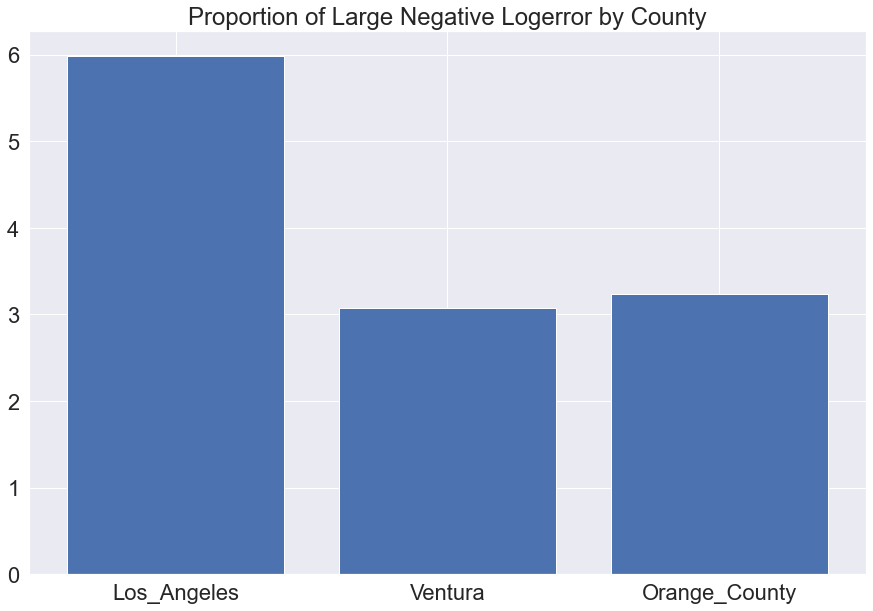

In [32]:
a = 0.05

chi2, p, degf, expected = stats.chi2_contingency(observed)

expected_df = pd.DataFrame(expected.round(2))

print(observed)
print(expected_df)
print("a is:", a)
print("p is:", p)
if p < a:
    print("we reject the null hypothesis that county and large, negative outlier membership are independent")
#plt.bar(data=observed, x=observed.index, y=observed.Proportion_of_County, height=)
plt.figure(figsize=(15, 10))
plt.title("Proportion of Large Negative Logerror by County")
plt.bar([0,1,2], observed.Proportion_of_County, align ='center')
plt.xticks([0,1,2], observed.index)

## B. Takeaway: LA County is almost twice as likely as both of the other two counties to have a large negative logerror

## Q2: Is high logerror related to SQ FT?

Text(0.5, 0.98, 'SQFT v. Logerror for (1) Population, (2) <2500 SQFT, (3) >2500 SQFT')

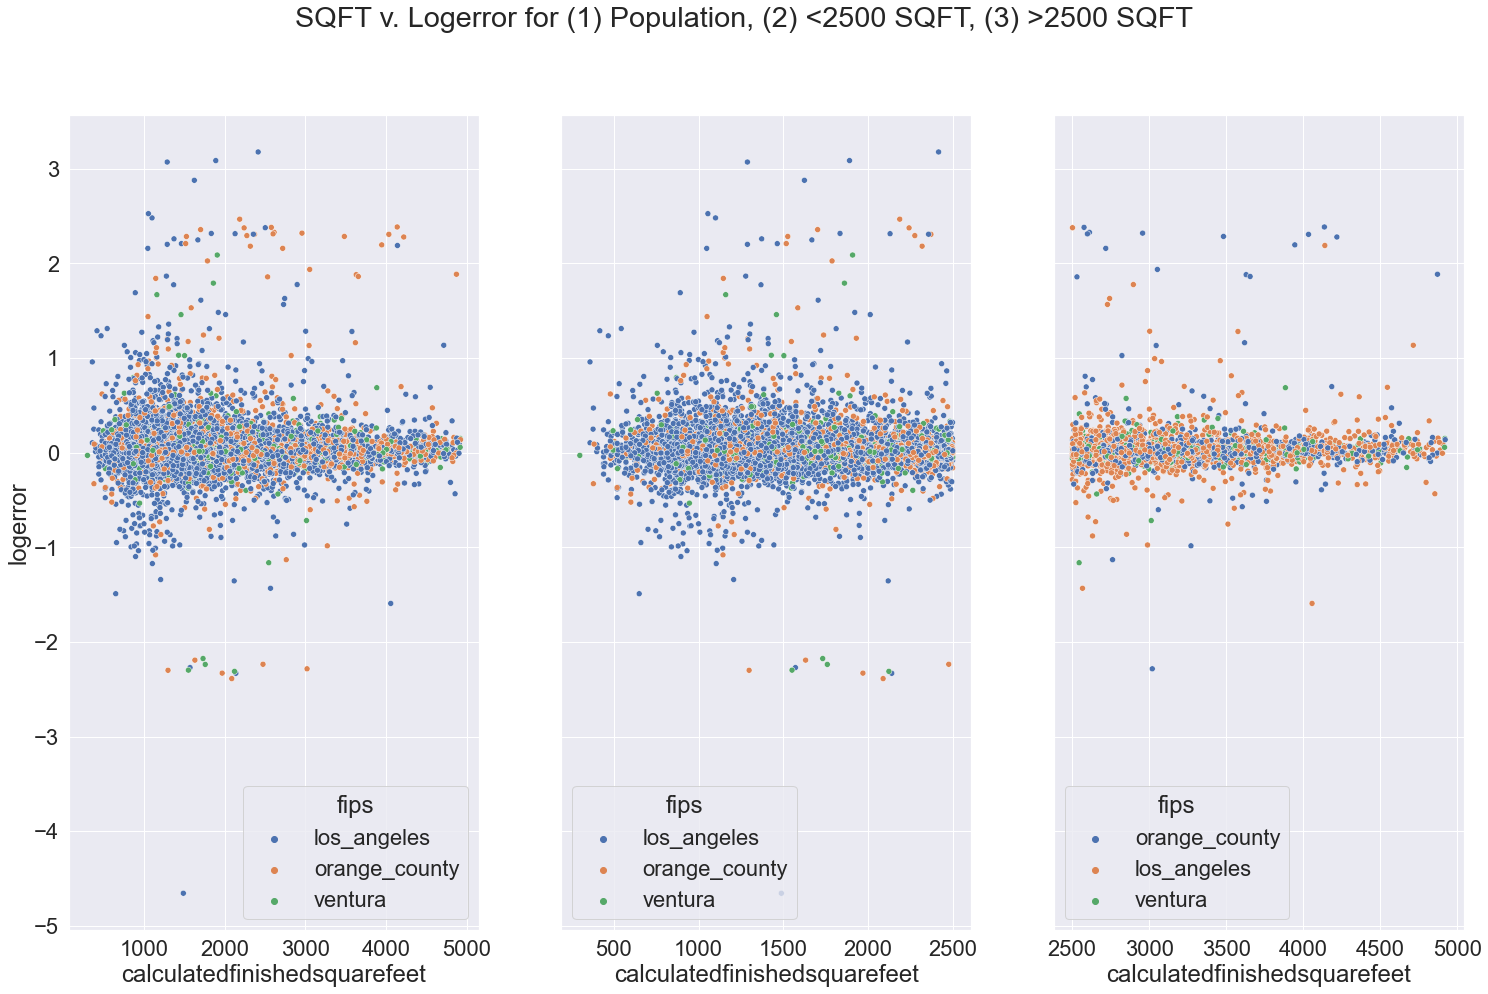

In [33]:
sns.set(font_scale = 2, rc={"figure.figsize":(25,15)})
fig, axes = plt.subplots(1, 3, sharey=True)

sns.scatterplot(y='logerror', x='calculatedfinishedsquarefeet', data=train, ax=axes[0], hue='fips')
sns.scatterplot(y='logerror', x='calculatedfinishedsquarefeet', data=train[train.calculatedfinishedsquarefeet < 2500], ax=axes[1], hue='fips')
sns.scatterplot(y='logerror', x='calculatedfinishedsquarefeet', data=train[train.calculatedfinishedsquarefeet > 2500], ax=axes[2], hue='fips')
fig.suptitle("""SQFT v. Logerror for (1) Population, (2) <2500 SQFT, (3) >2500 SQFT""")

## Takeaways:
- homes above 2500 SQ FT appear to have lower mean logerror.
- lets test statistically, (1 tail, indep t-test)
- then let's throw some clusters at this
- build menaningful clusters
- name the clusters
- run linear regresssion on those clusters

In [34]:
train['abs_logerror'] = train.logerror.abs()
train.head()

,logerror,transactiondate,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,latitude,longitude,lotsizesquarefeet,roomcnt,yearbuilt,taxvaluedollarcnt,logerror_bins,zillow_price_est,zillow_error,abs_logerror
3323,-0.021395,2017-01-24,2.0,3.0,1115.0,los_angeles,34212796.0,-118543472.0,13043.0,0.0,1956.0,254647.0,"(-0.25, 0.0]",249256.585265,-5390.414735,0.021395
2470,-0.023569,2017-01-18,1.0,2.0,1754.0,los_angeles,34105205.0,-118108463.0,8666.0,0.0,1938.0,582447.0,"(-0.25, 0.0]",568879.837510,-13567.162490,0.023569
7019,-0.083987,2017-02-16,3.0,4.0,2497.0,los_angeles,34465169.0,-118494179.0,18496.0,0.0,1989.0,462901.0,"(-0.25, 0.0]",425611.362951,-37289.637049,0.083987
50112,-0.039345,2017-09-06,3.0,3.0,1780.0,los_angeles,34567611.0,-118172344.0,5069.0,0.0,2005.0,260000.0,"(-0.25, 0.0]",249968.984278,-10031.015722,0.039345
48192,-0.048605,2017-08-29,2.0,5.0,1875.0,los_angeles,33966020.0,-118023774.0,5940.0,0.0,1951.0,522149.0,"(-0.25, 0.0]",497376.640046,-24772.359954,0.048605


## Test Statistically:
- Null hypothesis: the mean absolute logerror of homes >2500 SQFT is greater than the mean of homes <=2500 SQFT
- Alt hypothesis: homes >2500 SQFT have a lower mean log error than homes <=2500 SQ FT


In [35]:
# this is a one tailed t-test, so p/2 needs to be < a, and t>0
a = 0.05
train.calculatedfinishedsquarefeet[train.calculatedfinishedsquarefeet > 2500].count()

5067

In [36]:
train.calculatedfinishedsquarefeet[train.calculatedfinishedsquarefeet > 2500].var()

290266.7685040197

In [37]:
train.calculatedfinishedsquarefeet[train.calculatedfinishedsquarefeet < 2500].count()

23303

In [38]:
train.calculatedfinishedsquarefeet[train.calculatedfinishedsquarefeet < 2500].var()

197393.1439023926

In [39]:
big_house = train[train.calculatedfinishedsquarefeet > 2500]
little_house = train[train.calculatedfinishedsquarefeet < 2500]

big_house_mean_error = train.abs_logerror[train.calculatedfinishedsquarefeet > 2500]
little_house_mean_error = train.abs_logerror[train.calculatedfinishedsquarefeet < 2500]

little_house_mean_error.mean(), big_house_mean_error.mean()

(0.0687252901223104, 0.0738345634686237)

In [40]:
t, p = stats.ttest_ind(little_house_mean_error, big_house_mean_error, equal_var=False)

print(f"""t = {t}, p/2 = {p/2}, a = {a}""")

t = -1.9842292451349162, p/2 = 0.02363507522790706, a = 0.05


In [41]:
if (p/2 < a) and (t < 0):
    print("We reject the null hypothesis that the mean absolute logerror of homes >2500 SQFT is greater than the mean of homes <=2500 SQFT")
else:
    print("We reject the Alt hypothesis that homes >2500 SQFT have a lower mean log error than homes <=2500 SQ FT")

We reject the null hypothesis that the mean absolute logerror of homes >2500 SQFT is greater than the mean of homes <=2500 SQFT


## Q3: Is high logerror related to YR BUILT?

In [42]:
train.yearbuilt.mean()

1962.8208301519005

In [43]:
train.yearbuilt.median()

1960.0

Text(0.5, 0.98, 'YRBUILT v. Logerror for (1) Population, (2) 1900-40 (3) 1940-80 (4)1981-2017-')

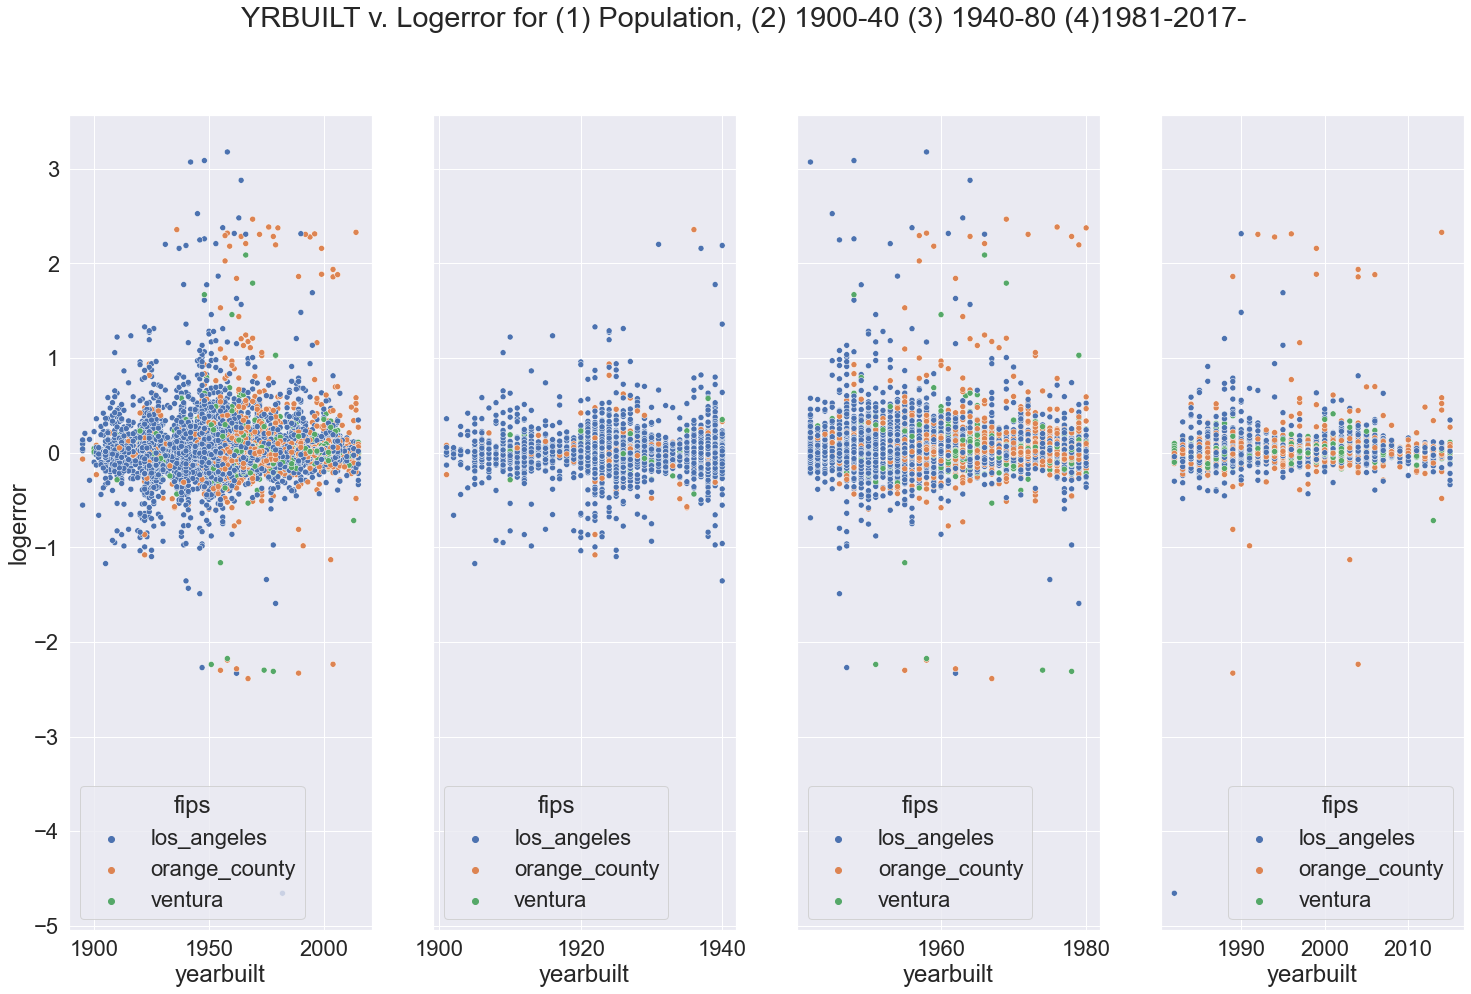

In [44]:
sns.set(font_scale = 2, rc={"figure.figsize":(25,15)})
fig, axes = plt.subplots(1, 4, sharey=True)

sns.scatterplot(y='logerror', x='yearbuilt', data=train, ax=axes[0], hue='fips')
sns.scatterplot(y='logerror', x='yearbuilt', data=train[(train.yearbuilt > 1900) & (train.yearbuilt < 1941)] , ax=axes[1], hue='fips')
sns.scatterplot(y='logerror', x='yearbuilt', data=train[(train.yearbuilt > 1941) & (train.yearbuilt < 1981)] , ax=axes[2], hue='fips')
sns.scatterplot(y='logerror', x='yearbuilt', data=train[(train.yearbuilt > 1981) & (train.yearbuilt < 2018)] , ax=axes[3], hue='fips')
fig.suptitle("""YRBUILT v. Logerror for (1) Population, (2) 1900-40 (3) 1940-80 (4)1981-2017-""")

## Takeaways:
- homes above 2500 SQ FT appear to have lower mean logerror.
- lets test statistically, (1 tail, indep t-test)
- then let's throw some clusters at this
- build menaningful clusters
- name the clusters
- run linear regresssion on those clusters

In [45]:
train['abs_logerror'] = train.logerror.abs()
train.head()

,logerror,transactiondate,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,latitude,longitude,lotsizesquarefeet,roomcnt,yearbuilt,taxvaluedollarcnt,logerror_bins,zillow_price_est,zillow_error,abs_logerror
3323,-0.021395,2017-01-24,2.0,3.0,1115.0,los_angeles,34212796.0,-118543472.0,13043.0,0.0,1956.0,254647.0,"(-0.25, 0.0]",249256.585265,-5390.414735,0.021395
2470,-0.023569,2017-01-18,1.0,2.0,1754.0,los_angeles,34105205.0,-118108463.0,8666.0,0.0,1938.0,582447.0,"(-0.25, 0.0]",568879.837510,-13567.162490,0.023569
7019,-0.083987,2017-02-16,3.0,4.0,2497.0,los_angeles,34465169.0,-118494179.0,18496.0,0.0,1989.0,462901.0,"(-0.25, 0.0]",425611.362951,-37289.637049,0.083987
50112,-0.039345,2017-09-06,3.0,3.0,1780.0,los_angeles,34567611.0,-118172344.0,5069.0,0.0,2005.0,260000.0,"(-0.25, 0.0]",249968.984278,-10031.015722,0.039345
48192,-0.048605,2017-08-29,2.0,5.0,1875.0,los_angeles,33966020.0,-118023774.0,5940.0,0.0,1951.0,522149.0,"(-0.25, 0.0]",497376.640046,-24772.359954,0.048605


## Test Statistically:
### 1900-40 abs mean error < 1981-2017 abs mean error < 1941-80 abs mean error:
- Null hypothesis1: the mean absolute logerror of homes built (1900-40) is greater than/equal to the mean abs error of homes built(1941-1980)
- Alt hypothesis1: the mean absolute logerror of homes built (1900-40) is less than the mean abs error of homes built(1941-1980)
- 

- Null hypothesis2: the mean absolute logerror of homes built (1941-80) is less than/equal to the mean abs error of homes built (1981-2017)
- Alt hypothesis2: the mean absolute logerror of homes built (1941-80) is greater than the mean abs error of homes built (1981-2017)

- Null hypothesis3: the mean absolute logerror of homes built (1981-2017) is less than/equal to  than the mean abs error of homes built (1941-1980)
- Alt hypothesis3: the mean absolute logerror of homes built (1981-2017) is greater than the mean abs error of homes built (1941-1980)


In [46]:
# these are one tailed t-tests, so p/2 needs to be < a, and t>0
a = 0.05

In [47]:
old_house = train[(train.yearbuilt > 1900) & (train.yearbuilt < 1941)]
mid_house = train[(train.yearbuilt > 1941) & (train.yearbuilt < 1981)]
new_house = train[(train.yearbuilt > 1981) & (train.yearbuilt < 2018)]

old_house_mean_error = old_house.abs_logerror
mid_house_mean_error = mid_house.abs_logerror
new_house_mean_error = new_house.abs_logerror

old_house_mean_error.mean(), mid_house_mean_error.mean(), new_house_mean_error.mean()

# now t test the means to get statistical significance

(0.10145771259675256, 0.06811438561101696, 0.05253258556584618)

### 1. Check samples for equal variance

In [48]:
old_house.abs_logerror.var(), mid_house.abs_logerror.var(), new_house.abs_logerror.var() 

(0.027829341053368435, 0.023139112528598623, 0.019849685921271346)

In [49]:
### - Null hypothesis1: the mean absolute logerror of homes built (1900-40) is greater than/equal to the mean abs error of homes built(1941-1980)
### - Alt hypothesis1: the mean absolute logerror of homes built (1900-40) is less than the mean abs error of homes built(1941-1980)
t, p = stats.ttest_ind(mid_house_mean_error, old_house_mean_error, equal_var=True)

print(f"""t = {t}, p/2 = {p/2}, a = {a}""")
if t >= 0:
    print("the mean logerror of homes built 1941-80 is greater than the mean logerror of homes built 1900-40")
else:
    print("the mean logerror of homes built 1900-40 is greater than the mean logerror of homes built 1941-80")
if (p/2 < a) and (t > 0):
    print("I reject the null hypothesis, that the mean absolute logerror of homes built (1900-40) is greater than/equal to the mean abs error of homes built(1941-1980)")
else:
    print("I reject the alternate hypothesis, that the mean absolute logerror of homes built (1900-40) is less than the mean abs error of homes built(1941-1980)")

t = -12.289047007765134, p/2 = 6.755435219931541e-35, a = 0.05
the mean logerror of homes built 1900-40 is greater than the mean logerror of homes built 1941-80
I reject the alternate hypothesis, that the mean absolute logerror of homes built (1900-40) is less than the mean abs error of homes built(1941-1980)


### Takeaway 1: mean LOGERROR is higher for homes built 1900-40 than for homes built 1941-80

### 2. Now that we know 1900-40 has the highest logerror so far, test the lesser (1940-80) against the remaining datset (1981-2017)

In [50]:
### - Null hypothesis1: the mean absolute logerror of homes built (1941-80) is greater than/equal to the mean abs error of homes built(1981-2017)
### - Alt hypothesis1: the mean absolute logerror of homes built (1941-80) is less than the mean abs error of homes built(1981-2017)
t, p = stats.ttest_ind(mid_house_mean_error, new_house_mean_error, equal_var=True)

print(f"""t = {t}, p/2 = {p/2}, a = {a}""")
if t >= 0:
    print("the mean logerror of homes built 1941-80 is greater than the mean logerror of homes built 1981-2017")
else:
    print("the mean logerror of homes built 1980-2017 is less than the mean logerror of homes built 1900-40")
if (p/2 < a) and (t < 0):
    print("I reject the null hypothesis, that the mean absolute logerror of homes built (1941-80) is greater than/equal to the mean abs error of homes built(1981-2017)")
else:
    print("I reject the alternate hypothesis, that the mean absolute logerror of homes built (1941-80) is less than the mean abs error of homes built(1981-2017)")


t = 7.052171119868797, p/2 = 9.047140903815048e-13, a = 0.05
the mean logerror of homes built 1941-80 is greater than the mean logerror of homes built 1981-2017
I reject the alternate hypothesis, that the mean absolute logerror of homes built (1941-80) is less than the mean abs error of homes built(1981-2017)


### Takeaway2: the mean absolute LOGERROR for homes built 1941-80 > mean absolute LOGERROR for homes built 1981-2017

### Final Ranking of YRBUILT mean LOGERRORs:
>> mean logerror for homes is grouped into to the following bands: 1900-40 > 1941-1980 > 1981-2017

## 3. Exploration with clustering: Let's see if clustering helps to group logerror along the statistically observed outcomes

In [60]:
train_ready = train.drop(columns=['taxvaluedollarcnt', 'logerror_bins', 'zillow_price_est',
       'zillow_error', 'abs_logerror', 'latitude', 'longitude'])


In [61]:
train_encoded = wrangle.encode_zillow(train_ready)

In [62]:
scaler = sklearn.preprocessing.MinMaxScaler()

train_encoded_scaled, validate_scaled, test_scaled = wrangle.fit_and_scale(scaler,train_encoded,validate, test)

In [63]:
from sklearn.cluster import KMeans

X = train_encoded_scaled
kmeans = KMeans(n_clusters = 4)

kmeans.fit(X)
kmeans.predict(X)
kmeans.cluster_centers_


array([[5.97601267e-01, 5.84841009e-01, 6.11586257e-01, 5.45326857e-01,
        4.32965711e-02, 3.37254120e-03, 7.41470212e-01],
       [5.96236311e-01, 4.03070616e-02, 2.63688086e-01, 1.73886947e-01,
        2.34271257e-02, 3.05160034e-02, 3.71207007e-01],
       [5.96871143e-01, 3.31418330e-01, 4.97735495e-01, 3.48162075e-01,
        2.91618268e-02, 6.28470150e-01, 6.26149575e-01],
       [5.96275266e-01, 2.88483888e-01, 4.45134707e-01, 2.89549921e-01,
        3.11879826e-02, 1.82490515e-04, 5.37639016e-01]])

In [64]:

centroids = pd.DataFrame(kmeans.cluster_centers_, columns=X.columns)
centroids

,logerror,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,lotsizesquarefeet,roomcnt,yearbuilt
0,0.597601,0.584841,0.611586,0.545327,0.043297,0.003373,0.741470
1,0.596236,0.040307,0.263688,0.173887,0.023427,0.030516,0.371207
2,0.596871,0.331418,0.497735,0.348162,0.029162,0.628470,0.626150
3,0.596275,0.288484,0.445135,0.289550,0.031188,0.000182,0.537639


In [65]:
train_encoded_scaled['cluster'] = kmeans.predict(X)

## Let's visually check that the K level that I set is appropriate for this dataset

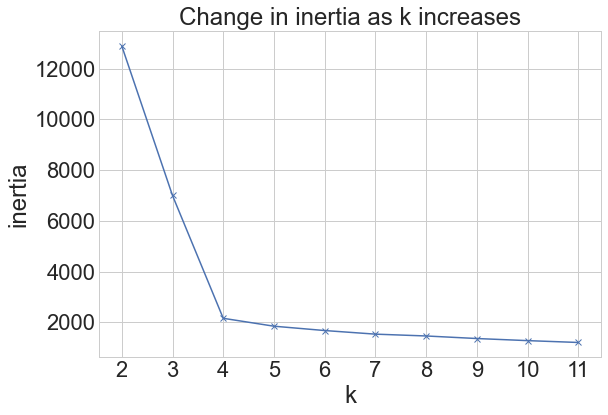

In [66]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(X).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

Text(0.5, 0.98, 'YRBUILT v. Logerror for (1) Population, (2) Clustered Population')

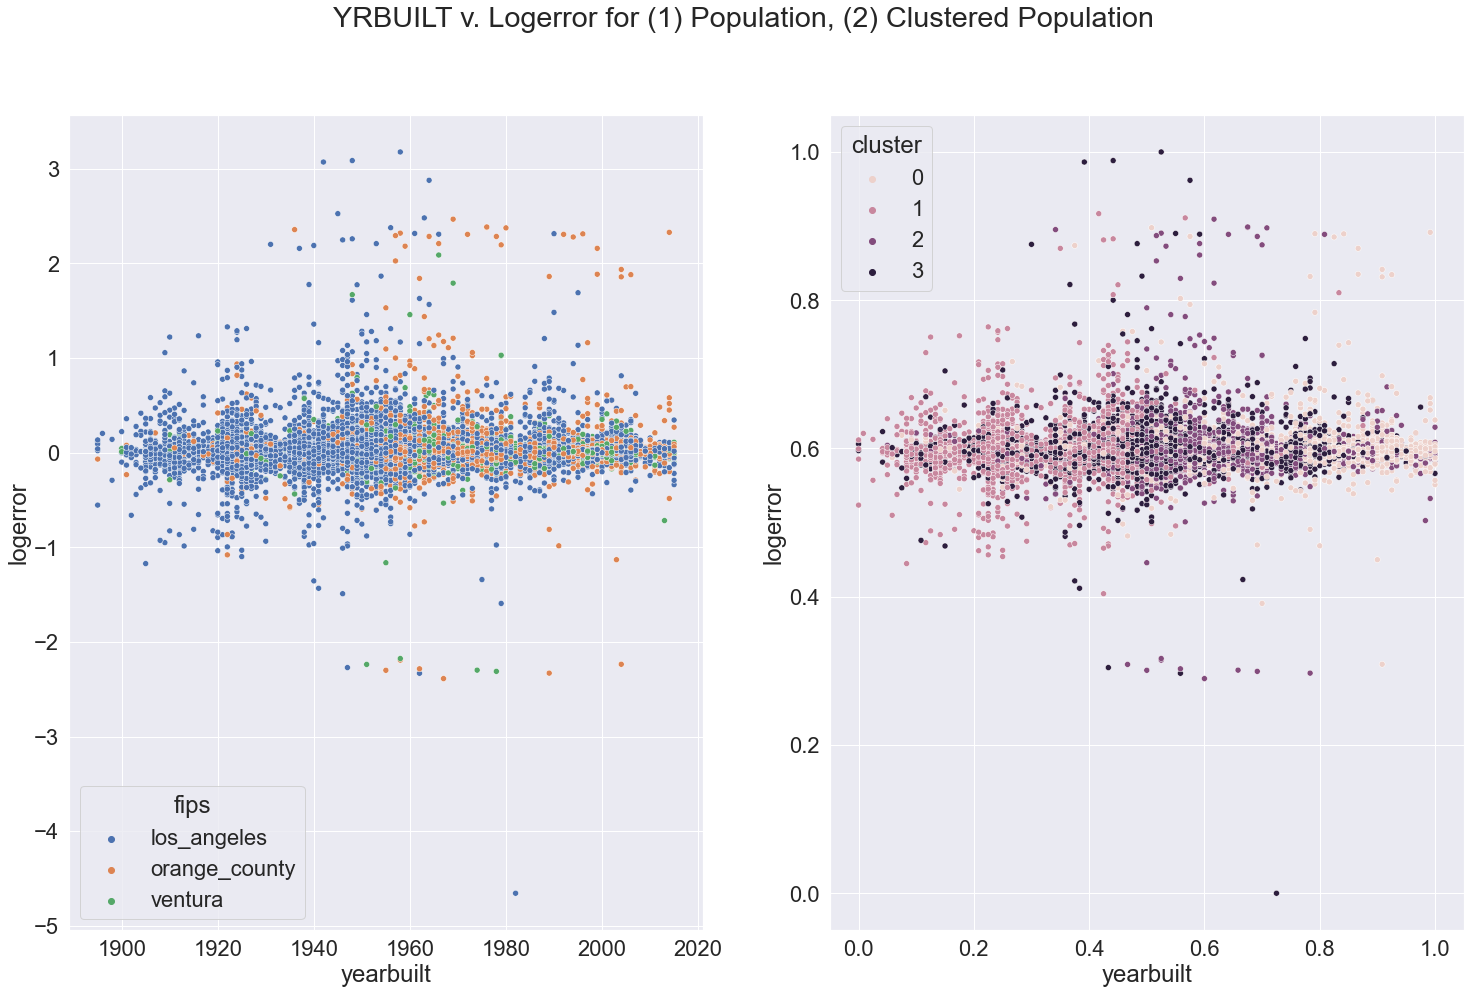

In [67]:
sns.set(font_scale = 2, rc={"figure.figsize":(25,15)})
fig, axes = plt.subplots(1, 2, sharey=False)

sns.scatterplot(y='logerror', x='yearbuilt', data=train, ax=axes[0], hue='fips')
sns.scatterplot(y='logerror', x='yearbuilt', data=train_encoded_scaled, ax=axes[1], hue='cluster')


fig.suptitle("""YRBUILT v. Logerror for (1) Population, (2) Clustered Population""")

## Clear differentiation with clusters pre- and post- 1963. It also looks like the clusters are grouping by county (fips)

Text(0.5, 0.98, 'SQFT v. Logerror for (1) Population, (2) <2500 SQFT, (3) >2500 SQFT, and Clusters (whole, 1st Half, 2nd Half')

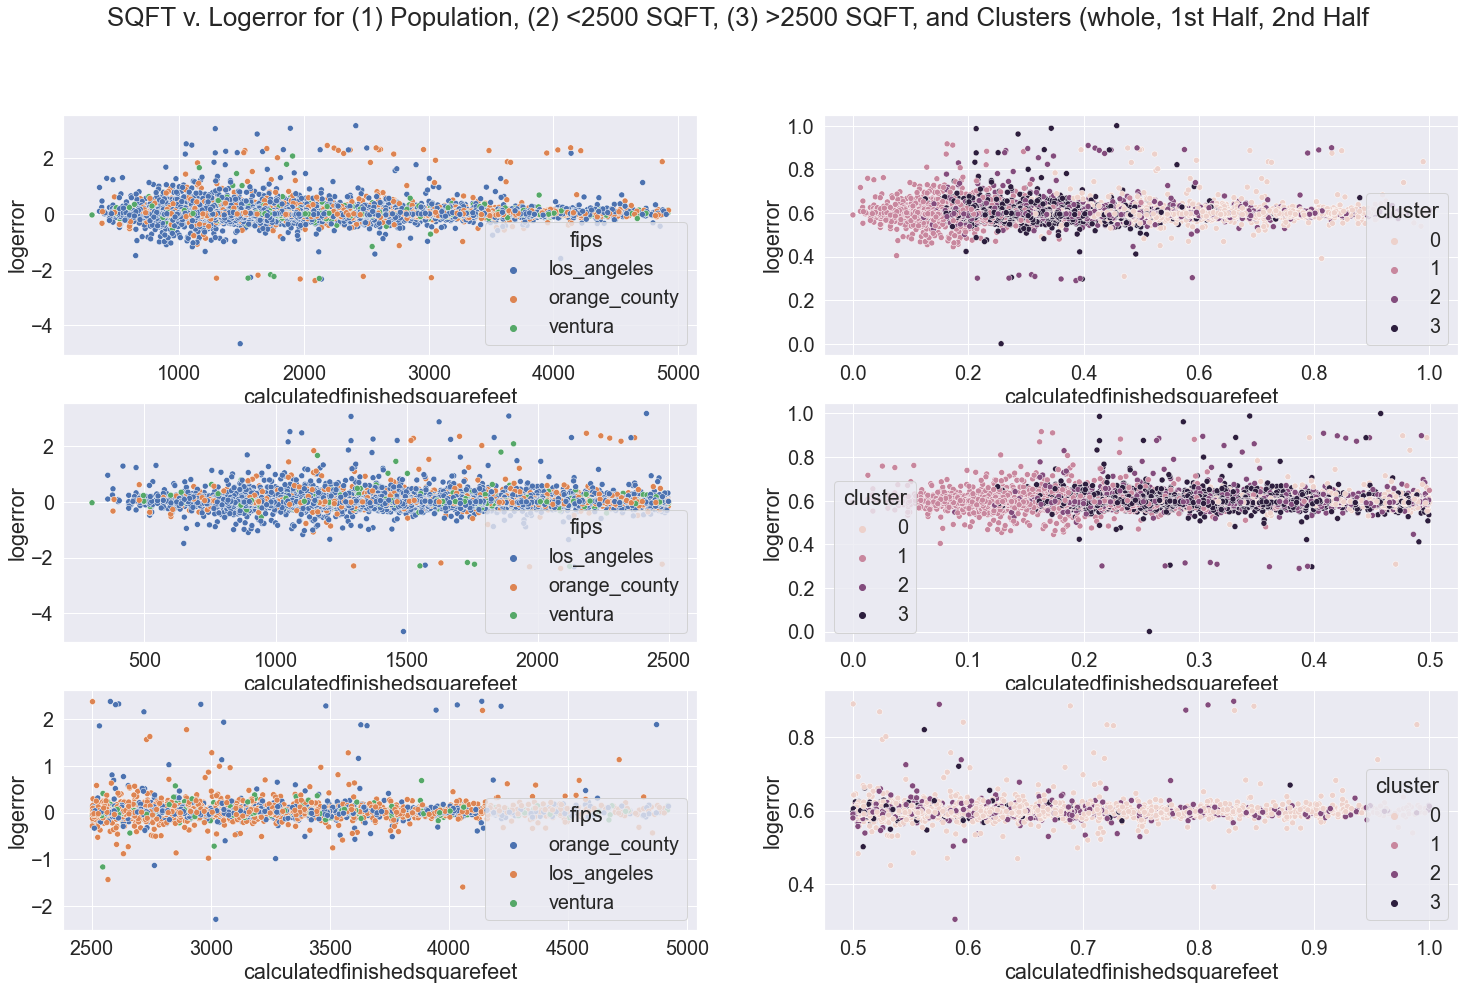

In [68]:
sns.set(font_scale = 1.8, rc={"figure.figsize":(25,15)})
fig, axes = plt.subplots(3, 2, sharey=False)

sns.scatterplot(y='logerror', x='calculatedfinishedsquarefeet', data=train, ax=axes[0,0], hue='fips')
sns.scatterplot(y='logerror', x='calculatedfinishedsquarefeet', data=train[train.calculatedfinishedsquarefeet < 2500], ax=axes[1,0], hue='fips')
sns.scatterplot(y='logerror', x='calculatedfinishedsquarefeet', data=train[train.calculatedfinishedsquarefeet > 2500], ax=axes[2,0], hue='fips')
sns.scatterplot(y='logerror', x='calculatedfinishedsquarefeet', data=train_encoded_scaled, ax=axes[0,1], hue='cluster')
sns.scatterplot(y='logerror', x='calculatedfinishedsquarefeet', data=train_encoded_scaled[train_encoded_scaled.calculatedfinishedsquarefeet < 0.5], ax=axes[1,1], hue='cluster')
sns.scatterplot(y='logerror', x='calculatedfinishedsquarefeet', data=train_encoded_scaled[train_encoded_scaled.calculatedfinishedsquarefeet > 0.5], ax=axes[2,1], hue='cluster')
fig.suptitle("""SQFT v. Logerror for (1) Population, (2) <2500 SQFT, (3) >2500 SQFT, and Clusters (whole, 1st Half, 2nd Half""")

## Validates the interpretation that there is a difference between houses along the lines of square feet. right around the midpoint value (although differences start to show up around 0.4 on scaled data)

## 4. Modeling with Clusters:
- The visualizations validate that the features FIPS, SQFT and YRBUILT are significant in terms of relating to the target variable logerror, so I'm gong to cluster on those three columns
- for this data set I'm going to use k=4 
- once clusters are made I'm going to run a linear regression on the dataframe with the clusters as features

In [69]:
df = wrangle.wrangle_zillow()

['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet', 'lotsizesquarefeet', 'roomcnt', 'yearbuilt', 'taxvaluedollarcnt']
       bathroomcnt  bedroomcnt  calculatedfinishedsquarefeet  \
0         1.173897    0.736871                      1.172918   
1         1.270673    1.370886                      0.456237   
2         0.292845    0.317008                      0.677444   
3         0.684983    0.736871                      0.451506   
4         0.684983    0.736871                      1.035411   
...            ...         ...                           ...   
52437     0.292845    1.370886                      0.634597   
52438     0.292845    0.736871                      0.309763   
52439     1.270673    0.317008                      0.887689   
52440     0.292845    0.317008                      0.160299   
52441     0.292845    0.317008                      0.869754   

       lotsizesquarefeet   roomcnt  yearbuilt  taxvaluedollarcnt  
0               0.079053  0.601872  

In [70]:
### split the data

In [71]:
train, validate, test = split.train_validate_test_split(df, df.logerror)

In [72]:
## drop additional columns as needed to prevent dummying of 'object' types, and target variable leak

In [73]:
train.columns
train = train.drop(columns=['latitude', 'longitude', 'taxvaluedollarcnt', 'transactiondate'])

In [74]:
validate = validate.drop(columns=['latitude', 'longitude', 'taxvaluedollarcnt', 'transactiondate'])

In [75]:
test = test.drop(columns=['latitude', 'longitude', 'taxvaluedollarcnt', 'transactiondate'])

In [76]:
## encode the necessary variables

In [77]:
encoded_train = wrangle.encode_zillow(train)
encoded_validate = wrangle.encode_zillow(validate)
encoded_test = wrangle.encode_zillow(test)

In [78]:
### scale the variables for clustering

In [79]:
scaler = sklearn.preprocessing.MinMaxScaler()

encoded_train_scaled, encoded_validate_scaled, encoded_test_scaled = wrangle.fit_and_scale(scaler,encoded_train,encoded_validate, encoded_test)

In [80]:
from sklearn.cluster import KMeans

X = encoded_train_scaled
X2 = encoded_validate_scaled
X3 = encoded_test_scaled
kmeans = KMeans(n_clusters = 4)

kmeans.fit(X)
kmeans.fit(X2)
kmeans.fit(X3)
kmeans.predict(X)
kmeans.predict(X2)
kmeans.predict(X3)
kmeans.cluster_centers_


array([[5.95957851e-01, 2.88906297e-01, 4.41122053e-01, 2.89750174e-01,
        3.23086271e-02, 8.13868316e-05, 5.43755595e-01],
       [5.97322864e-01, 3.37022323e-01, 5.04502459e-01, 3.55465543e-01,
        2.83968988e-02, 6.31788945e-01, 6.27388622e-01],
       [5.95564815e-01, 3.85746606e-02, 2.64524887e-01, 1.73224530e-01,
        2.38627197e-02, 3.51707116e-02, 3.71761619e-01],
       [5.98455238e-01, 5.85706888e-01, 6.15846712e-01, 5.49799206e-01,
        4.25689781e-02, 2.68348948e-03, 7.44501985e-01]])

In [81]:
centroids = pd.DataFrame(kmeans.cluster_centers_, columns=X.columns)
centroids

,logerror,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,lotsizesquarefeet,roomcnt,yearbuilt
0,0.595958,0.288906,0.441122,0.289750,0.032309,0.000081,0.543756
1,0.597323,0.337022,0.504502,0.355466,0.028397,0.631789,0.627389
2,0.595565,0.038575,0.264525,0.173225,0.023863,0.035171,0.371762
3,0.598455,0.585707,0.615847,0.549799,0.042569,0.002683,0.744502


In [82]:
encoded_train_scaled['cluster'] = kmeans.predict(X)
encoded_validate_scaled['cluster'] = kmeans.predict(X2)
encoded_test_scaled['cluster'] = kmeans.predict(X3)
encoded_train_scaled.head()

,logerror,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,lotsizesquarefeet,roomcnt,yearbuilt,cluster
0,0.591746,0.25,0.4,0.176331,0.046697,0.0,0.508333,0
1,0.591468,0.00,0.2,0.314582,0.030350,0.0,0.358333,2
2,0.583753,0.50,0.6,0.475335,0.067063,0.0,0.783333,3
3,0.589454,0.50,0.4,0.320208,0.016915,0.0,0.916667,3
4,0.588271,0.25,0.8,0.340762,0.020168,0.0,0.466667,0


In [83]:
### X+y split for modeling

In [84]:
X_train = encoded_train.drop(columns='logerror')
y_train = encoded_train.drop(columns=X_train)

X_validate = encoded_validate.drop(columns='logerror')
y_validate = encoded_validate.drop(columns=X_validate)

X_test = encoded_test.drop(columns='logerror')
y_test = encoded_test.drop(columns=X_test)

## Now that the data has been scaled, encoded and clusters have been added as a feature we are ready for modeling with clusters.

In [85]:
#scale the x sets

In [86]:
X_scaled_train, X_scaled_validate, X_scaled_test = wrangle.fit_and_scale(scaler, X_train, X_validate, X_test)

<h3> Calculate Baseline Error </h3>

In [87]:
# modeling methods
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures

In [88]:
# the baseline prediction is equal to the mean home price for all homes

In [89]:
# add baseline for y_train
y_train['logerror'] = y_train.logerror.mean()
y_train['logerror_baseline'] = y_validate.logerror.mean()
#compute residual error for the baseline prediction:
y_train['baseline_residual'] = y_train.logerror - y_train.logerror_baseline


In [90]:
# compute baseline RMSE
baseline_RMSE = mean_squared_error(y_train.logerror, y_train.logerror_baseline)**(1/2)
print("The baseline RMSE is:", baseline_RMSE)

The baseline RMSE is: 0.0007900169305903036


## Modeling Logerror with Cluster Feature: Polynomial Regression

### I selected the best performing model from the Regression Project I previously completed.

In [91]:
# based on the scatter plot distributions, I believe that degree=2 is appropriate
# for the polynomial regression model
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=2)

# fit and transform X_train_scaled
X_scaled_train_degree2 = pf.fit_transform(X_scaled_train)

# transform X_validate_scaled & X_test_scaled
X_scaled_validate_degree2 = pf.transform(X_scaled_validate)
X_scaled_test_degree2 = pf.transform(X_scaled_test)

In [92]:
# Linear Regression (OLS)
# create the model object
lm2 = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm2.fit(X_scaled_train_degree2, y_train.logerror)

# predict price on train dataset
y_train['train_poly_pred_logerror'] = lm2.predict(X_scaled_train_degree2)

# evaluate: rmse
poly_rmse_train = mean_squared_error(y_train.logerror, y_train.train_poly_pred_logerror)**(1/2)

# predict validate
y_validate['validate_poly_pred_logerror'] = lm2.predict(X_scaled_validate_degree2)

# evaluate: rmse
poly_rmse_validate = mean_squared_error(y_validate.logerror, y_validate.validate_poly_pred_logerror)**(1/2)

print("RMSE for Polynomial Regression using LinearRegression\nTraining/In-Sample: ", poly_rmse_train, 
      "\nValidation/Out-of-Sample: ", poly_rmse_validate)

RMSE for Polynomial Regression using LinearRegression
Training/In-Sample:  3.469446951953614e-18 
Validation/Out-of-Sample:  0.17297168885244302


In [93]:
# Linear Regression (OLS)
# create the model object
lm2 = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm2.fit(X_scaled_train_degree2, y_train.logerror)

# predict test
test_poly_pred_logerror = lm2.predict(X_scaled_test_degree2)

# evaluate: rmse
poly_rmse_test = mean_squared_error(y_test.logerror, test_poly_pred_logerror)**(1/2)

print("RMSE for Polynomial Regression using LinearRegression\nTraining/In-Sample: ", poly_rmse_train,
      "\nValidate/Out-of-Sample: ", poly_rmse_validate,
      "\nTest/Out-of-Sample: ", poly_rmse_test)

RMSE for Polynomial Regression using LinearRegression
Training/In-Sample:  3.469446951953614e-18 
Validate/Out-of-Sample:  0.17297168885244302 
Test/Out-of-Sample:  0.1840461169272749


## 5. Conclusions and Findings From Clustering :
- clustering did not significantly improve the modeling process when incorporated as a feature
    - my cluster features were SQ FT, YR BUILT, and FIPS
- clustering was helpful in identifying and narrowing variable connection to the target variable, LOGERROR
- I found SQ FT, YR BUILT and FIPS to be the main drivers of LOGERROR
- LOGERROR RMSE baseline: 0.0007
- LOGERROR RMSE with clusters in the model: 0.183

## 6. Recommendations and Next Steps :
- I think that clustering will be more useful with a categorical target variable, but cannot recommend using the model with current performance and clusters as a feature
- perhaps a more targeted cluster (focused on home size) or several groups of targeted clusters can be meaningfully incorporated into a predictive model in the future.